In [19]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os,sys
from astropy.modeling import models
import astropy.units as u
from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region
from specutils.fitting import fit_lines
from specutils.fitting import continuum 
from astropy import constants as const
from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import estimate_line_parameters
from astropy.modeling import fitting
from astropy.modeling.fitting import LevMarLSQFitter
#fitter = fitting.LevMarLSQFitter(calc_uncertainties=True)
fitter = fitting.LevMarLSQFitter()
from scipy.signal import savgol_filter
from extinction import ccm89, apply, remove,Fitzpatrick99
import extinction
from astropy.modeling.functional_models import Gaussian1D
from astropy.convolution import convolve_models
from astropy.modeling.polynomial import Chebyshev1D



In [20]:
line_list = { # these are all in air not vacuum
    'H-alpha': 6562.80,
    'H-beta': 4861.333,
    'OIII 4959': 4958.911,
    'OIII_2 5007': 5006.843,
    'NII 6548': 6548.050 ,
    'NII_2 6583': 6583.460,
    'SII 6716': 6716.440,
    'SII_2 6731': 6730.810,
    #
    'N III': 4097.36,
    'N III_2': 4103.39,
    'H I  ': 4340.47,
    'He II': 4541.49,
    'N III': 4634.14,
    'N III_2': 4640.64,
    'C III 4647': 4647.42,
    'C III 4650': 4650.25,
    'He II 4685': 4685.8,
    'He II 4859': 4859.32,
    'He II 5412': 5411.52,
    'C III 5696': 5695.92,
    'C IV 5801': 5801.31,
    'C IV_2 5812': 5811.97,   
    #
    'DIB 5780': 5780, #Diffuse Interstellar Bands - absorption of light by the interstellar medium, PAH and carbon
    'DIB 4428': 4428,
    'DIB 6379': 6379,
    #
    'NA ID 5893': 5892.9, #Sodium doublet combined wavelength
    'NA ID 1': 5889.951, #https://iopscience.iop.org/article/10.3847/1538-4357/abc017/pdf
    'NA ID 2': 5895.924, #https://iopscience.iop.org/article/10.3847/1538-4357/abc017/pdf
    'CA_II 3969': 3968.5, #“Calcium H and K
    'K 7665': 7664.9, # potassium doublet
    'KI 7699': 7698.96,
    'LI 6706': 6707, #Lithium 
    'CN 3883': 3883.4, #Copernicium
}



In [21]:
# read in spectrum
file='2021sjt-LRIS-2021-07-08.csv'
data = np.genfromtxt(file,names=True,comments='#', delimiter=',')

wav=data['wavelength']
flux=data['flux']
fluxerr=data['fluxerr']

# give spectrum correct units
flux1 = flux * 10**(-15) * u.Unit('erg cm-2 s-1 AA-1')
fluxerr1 = fluxerr * 10**(-15) * u.Unit('erg cm-2 s-1 AA-1')
wav1 = wav * u.AA # wavelength in Angstroms

z=0.00475 # redshift of the SN



In [22]:

# Step 1 - Apply Galactic extinction correction to the spectrum

# E(B-V) =  0.328
# R_V = 3.1$;  changes the shape of the extinction curve, rather than just the amplitude. A_V is linear scaling
# Cardelli, Clayton & Mathis (1989) R_V = 3.1
# R_V=A_V/E(B-V), where E(B-V) is the difference in extinction between the B and V bands 
# A_V = R_V * E(B-V) = 3.1 * 0.328 = 1.0168
# "deredden" flux by 1.0168
# https://extinction.readthedocs.io/en/latest/api/extinction.fitzpatrick99.html
dereddened_flux=remove(extinction.fitzpatrick99(wav1, a_v=1.0168, r_v=3.1), flux1) # correct for milky way extinction


# Step 2 - Correct spectrum wavelength for redshift
wav1=wav1/(1+z)

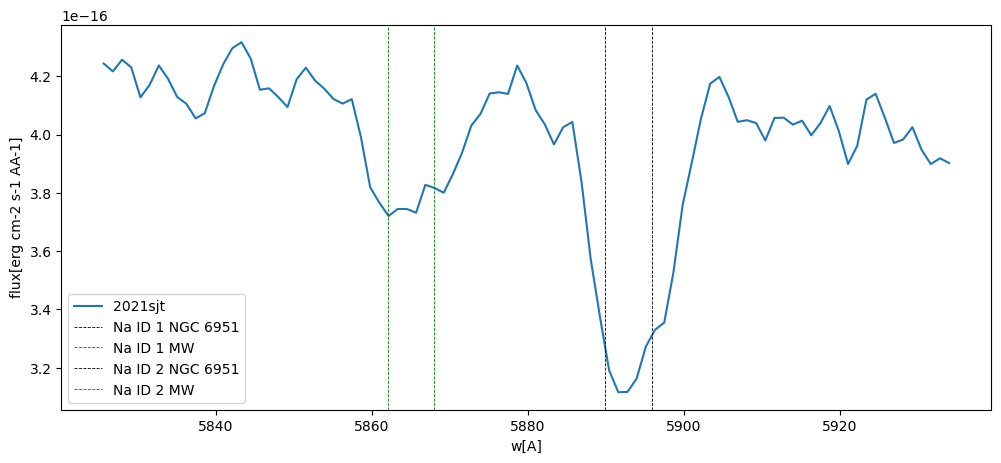

In [23]:
wav_region_left=5825 * u.AA
wav_region_right=5935 * u.AA
ind=np.where((wav1>wav_region_left) & (wav1<wav_region_right))
fig, ax = plt.subplots(figsize=(12,5),nrows=1, ncols=1)
ax.plot(wav1[ind], dereddened_flux[ind], label = '2021sjt')

# plot Na ID absorption from 2021sjt, 
ax.axvline(line_list['NA ID 1'], color='black', linestyle='--',linewidth=0.6, label = 'Na ID 1 NGC 6951')
ax.axvline(line_list['NA ID 1']/(1+z), color='green', linestyle='--',linewidth=0.6, label = 'Na ID 1 MW')

ax.axvline(line_list['NA ID 2'], color='black', linestyle='--',linewidth=0.6, label = 'Na ID 2 NGC 6951')
ax.axvline(line_list['NA ID 2']/(1+z), color='green', linestyle='--',linewidth=0.6, label = 'Na ID 2 MW')

plt.legend()
plt.xlabel("w[A]")
ax.set_ylabel("flux[erg cm-2 s-1 AA-1]")
plt.show()



In [24]:
#only NA_ID_1_X is varying, NA_ID_2_X is just an offset
NA_ID_1_NGC=line_list['NA ID 1']
NA_ID_2_NGC_line=line_list['NA ID 2']
NA_ID_NGC_DIFF = NA_ID_2_NGC_line - NA_ID_1_NGC
NA_ID_2_NGC = NA_ID_1_NGC + 5.973
print(NA_ID_NGC_DIFF, NA_ID_1_NGC, NA_ID_2_NGC)

NA_ID_1_MW=line_list['NA ID 1']/(1+z)
NA_ID_2_MW_line=line_list['NA ID 2']/(1+z)
NA_ID_MW_DIFF = NA_ID_2_MW_line - NA_ID_1_MW
NA_ID_2_MW = NA_ID_1_MW + 5.973
print(NA_ID_MW_DIFF, NA_ID_1_MW, NA_ID_2_MW)

spectrum = Spectrum1D(flux=dereddened_flux , spectral_axis=wav1)
sub_region = SpectralRegion(wav1[ind].min(), wav1[ind].max())
print(sub_region)
sub_spectrum = extract_region(spectrum, sub_region)
print(sub_spectrum)
line_estimates=estimate_line_parameters(sub_spectrum, models.Gaussian1D())

5.972999999999956 5889.951 5895.924
5.944762378701853 5862.105996516546 5868.078996516546
Spectral Region, 1 sub-regions:
  (5825.672057725802 Angstrom, 5933.986563821846 Angstrom) 

Spectrum1D (length=93)
flux:             [ 4.2435e-16 erg / (Angstrom cm2 s), ..., 3.9021e-16 erg / (Angstrom cm2 s) ],  mean=3.9696e-16 erg / (Angstrom cm2 s)
spectral axis:    [ 5825.7 Angstrom, ..., 5934.0 Angstrom ],  mean=5879.8 Angstrom


NA ID I NGC
5889.593681341101 5889.951
redshift=-0.000061
amplitude=4.043128320326565e-16
mean=5889.593681
std=2.728801

NA ID 2 NGC
5895.881888056998 5895.924
redshift=-0.000007
amplitude=3.7576611400919736e-16
mean=5895.881888
std=2.713815

NA ID I MW
5862.096634301943 5862.105996516546
redshift=-0.000002
amplitude=4.121368569737399e-16
mean=5862.096634
std=3.069542

NA ID 2 MW
5868.122653325503 5868.078996516546
redshift=0.000007
amplitude=4.0302969792650772e-16
mean=5868.122653
std=3.049668

5889.593681341101


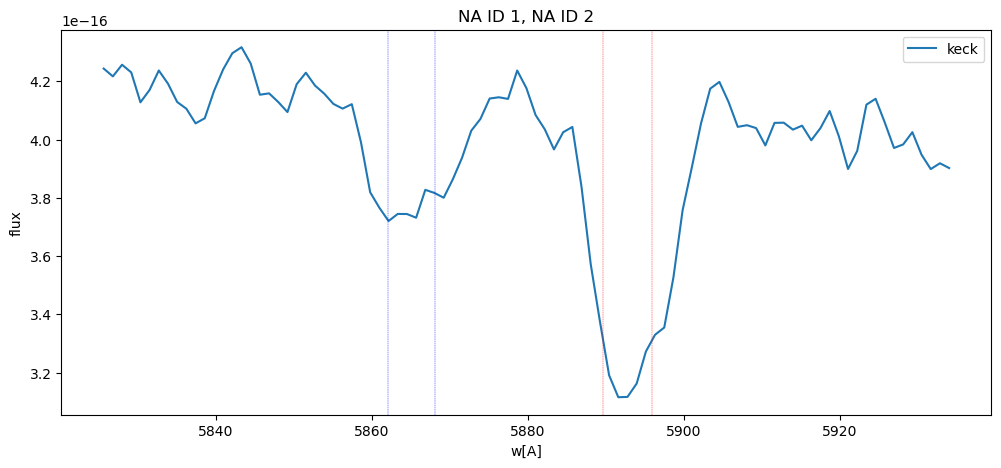

In [25]:
# Step 3 - Normalise the spectrum by modelling the continuum
# NA ID 1, NA ID 2


fig, ax = plt.subplots(figsize=(12,5),nrows=1, ncols=1)
ax.plot(wav1[ind], dereddened_flux[ind], label = 'keck')

#ax.axvline(NA_ID_CENTRAL_MW_FINAL, color='blue', linestyle='--',alpha=0.9,linewidth=0.3, label = 'NA ID CENTRAL MW')
ax.legend()

#ax.plot(kwav,wflux, label = 'keck')
#ax.set_xlim(xmin=6540, xmax=6600)



region = 5


############################################################################
# get params for first NA ID NGC 6951 line
sub_region1 = SpectralRegion((NA_ID_1_NGC-region)*u.AA, (NA_ID_1_NGC+region)*u.AA)
sub_spectrum1 = extract_region(spectrum, sub_region1)
line_estimates1=estimate_line_parameters(sub_spectrum1, models.Gaussian1D())

print('NA ID I NGC')
print(line_estimates1.mean.value, NA_ID_1_NGC)
print('redshift=%.6f'%((line_estimates1.mean.value-NA_ID_1_NGC)/NA_ID_1_NGC))
print('amplitude=%s'%line_estimates1.amplitude.value)
print('mean=%.6f'%line_estimates1.mean.value)
print('std=%.6f'%line_estimates1.stddev.value)
print('')

##########################################################################
#get params for second line
sub_region2 = SpectralRegion((NA_ID_2_NGC-region)*u.AA, (NA_ID_2_NGC+region)*u.AA)
sub_spectrum2 = extract_region(spectrum, sub_region2)
line_estimates2=estimate_line_parameters(sub_spectrum2, models.Gaussian1D())

print('NA ID 2 NGC')
print(line_estimates2.mean.value, NA_ID_2_NGC)
print('redshift=%.6f'%((line_estimates2.mean.value-NA_ID_2_NGC)/NA_ID_2_NGC))
print('amplitude=%s'%line_estimates2.amplitude.value)
print('mean=%.6f'%line_estimates2.mean.value)
print('std=%.6f'%line_estimates2.stddev.value)
print('')

##########################################################################
#get params for central line ngc
#sub_region_central_ngc = SpectralRegion((NA_ID_CENTRAL_NGC_FINAL-region)*u.AA, (NA_ID_CENTRAL_NGC_FINAL+region)*u.AA)
#sub_spectrum_central_ngc = extract_region(spectrum, sub_region_central_ngc)
#line_estimates_central_ngc=estimate_line_parameters(sub_spectrum_central_ngc, models.Gaussian1D())

#print('NA ID CENTRAL NGC')
#print(line_estimates_central_ngc.mean.value, NA_ID_CENTRAL_NGC_FINAL)
#print('redshift=%.6f'%((line_estimates_central_ngc.mean.value-NA_ID_CENTRAL_NGC_FINAL)/NA_ID_CENTRAL_NGC_FINAL))
#print('amplitude=%s'%line_estimates_central_ngc.amplitude.value)
#print('mean=%.6f'%line_estimates_central_ngc.mean.value)
#print('std=%.6f'%line_estimates_central_ngc.stddev.value)
#print('')

############################################################################
# get params for first NA ID MW line
sub_region3 = SpectralRegion((NA_ID_1_MW-region)*u.AA, (NA_ID_1_MW+region)*u.AA)
sub_spectrum3 = extract_region(spectrum, sub_region3)
line_estimates3=estimate_line_parameters(sub_spectrum3, models.Gaussian1D())

print('NA ID I MW')
print(line_estimates3.mean.value, NA_ID_1_MW)
print('redshift=%.6f'%((line_estimates3.mean.value-NA_ID_1_MW)/NA_ID_1_MW))
print('amplitude=%s'%line_estimates3.amplitude.value)
print('mean=%.6f'%line_estimates3.mean.value)
print('std=%.6f'%line_estimates3.stddev.value)
print('')

##########################################################################
#get params for second line
sub_region4 = SpectralRegion((NA_ID_2_MW-region)*u.AA, (NA_ID_2_MW+region)*u.AA)
sub_spectrum4 = extract_region(spectrum, sub_region4)
line_estimates4=estimate_line_parameters(sub_spectrum4, models.Gaussian1D())

print('NA ID 2 MW')
print(line_estimates4.mean.value, NA_ID_2_MW)
print('redshift=%.6f'%((line_estimates4.mean.value-NA_ID_2_MW)/NA_ID_2_MW))
print('amplitude=%s'%line_estimates4.amplitude.value)
print('mean=%.6f'%line_estimates4.mean.value)
print('std=%.6f'%line_estimates4.stddev.value)
print('')

##########################################################################
#get params for central line mw
#sub_region_central_mw = SpectralRegion((NA_ID_CENTRAL_MW_FINAL-region)*u.AA, (NA_ID_CENTRAL_MW_FINAL+region)*u.AA)
#sub_spectrum_central_mw = extract_region(spectrum, sub_region_central_mw)
#line_estimates_central_mw=estimate_line_parameters(sub_spectrum_central_mw, models.Gaussian1D())

#print('NA ID CENTRAL MW')
#print(line_estimates_central_mw.mean.value, NA_ID_CENTRAL_MW_FINAL)
#print('redshift=%.6f'%((line_estimates_central_mw.mean.value-NA_ID_CENTRAL_MW_FINAL)/NA_ID_CENTRAL_MW_FINAL))
#print('amplitude=%s'%line_estimates_central_mw.amplitude.value)
#print('mean=%.6f'%line_estimates_central_mw.mean.value)
#print('std=%.6f'%line_estimates_central_mw.stddev.value)
#print('')
print(line_estimates1.mean.value)
ax.axvline(line_estimates1.mean.value, color='red', linestyle='--',linewidth=0.3, label = 'NA ID 1 NGC 6951')
ax.axvline(line_estimates2.mean.value, color='red', linestyle='--',linewidth=0.3, label = 'NA ID 2 NGC 6961')

ax.axvline(line_estimates3.mean.value, color='blue', linestyle='--',linewidth=0.3, label = 'NA ID 1 MW')
ax.axvline(line_estimates4.mean.value, color='blue', linestyle='--',linewidth=0.3, label = 'NA ID 2 MW')

plt.title("NA ID 1, NA ID 2")
plt.xlabel("w[A]")
ax.set_ylabel("flux")
plt.show()

In [26]:
line_estimates.amplitude.value,line_estimates.mean.value,line_estimates.stddev.value,

(4.31681251579125e-16, 5879.161145706215, 31.990083648476965)

NA ID I NGC norm:
5889.598128332988 5889.951
redshift=-0.000060
amplitude=0.9759386305293404
mean=5889.598128
std=2.729123

NA ID 2 NGC norm:
5895.886981467385 5895.924
redshift=-0.000006
amplitude=0.9153289586670376
mean=5895.886981
std=2.713695

NA ID I MW norm:
5862.0982816909955 5862.105996516546
redshift=-0.000001
amplitude=0.9859163029082358
mean=5862.098282
std=3.069646

NA ID 2 MW norm:
5868.125115564388 5868.078996516546
redshift=0.000008
amplitude=0.9673793020849677
mean=5868.125116
std=3.049719

g_NA_ID_1_NGC: -0.2504806278493746
g_NA_ID_2_NGC: -0.1098370153151052
g_NA_ID_1_MW:-0.10786221990000015
g_NA_ID_2_MW: -0.07704961816965933
line flux NA ID NGC : -0.4278118023002577, AA
line flux NA ID MW : -0.21784568398800946, AA
Simpson integration of spectrum: 47.77683341148179
Simpson integration of fitted guassian MW : -1.1626136669897318
Simpson integration of fitted guassian NGC : -2.283185244405865


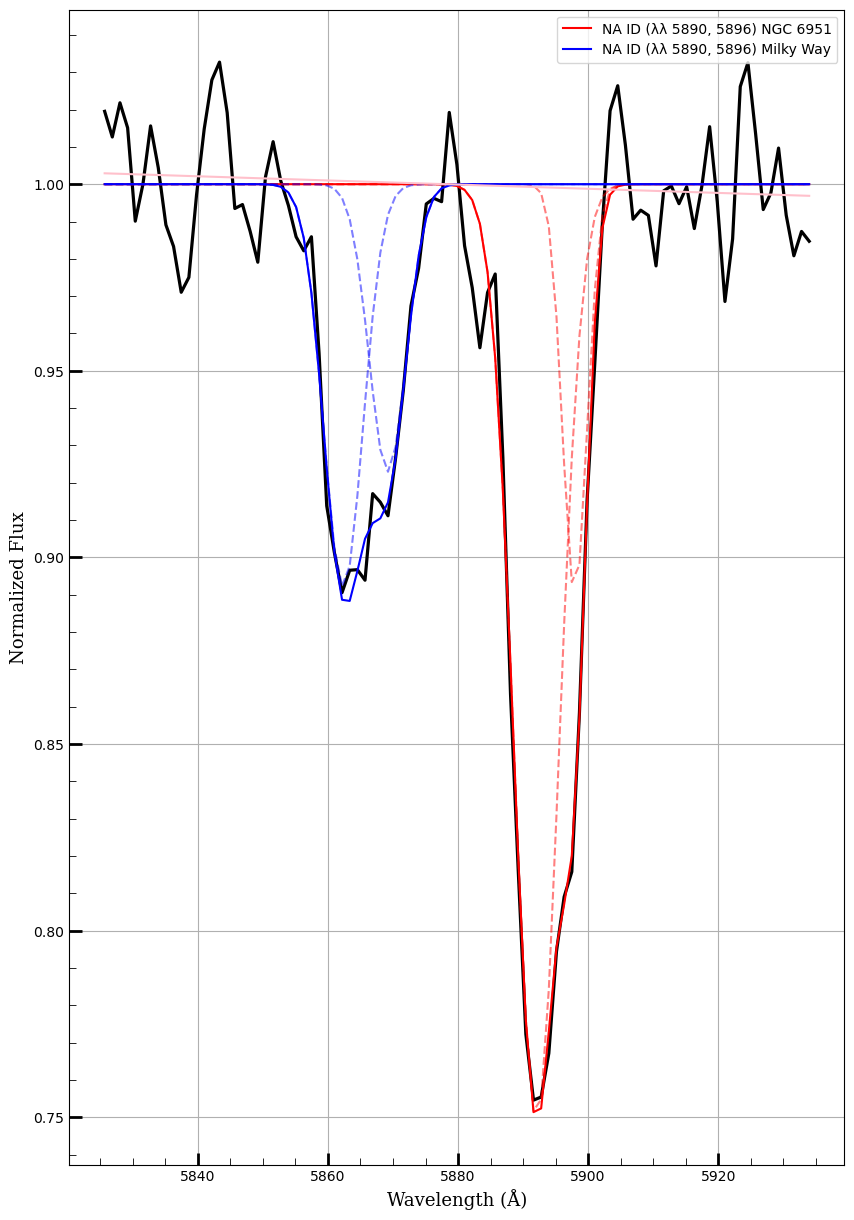

In [35]:
from astropy.modeling.polynomial import Chebyshev1D
from specutils.fitting import continuum 
from specutils.manipulation import FluxConservingResampler, LinearInterpolatedResampler, SplineInterpolatedResampler, gaussian_smooth
from matplotlib.ticker import MultipleLocator
from scipy import integrate
from specutils.analysis import line_flux, equivalent_width

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 13,
        }

# 1. Model continuum
# 2. Divide spectrum by continuum

#### Fit the spectrum

####non-normalized spectrum
#g_NA_ID_1_NGC = models.Gaussian1D(amplitude=line_estimates1.amplitude.value, mean=line_estimates1.mean.value*u.AA, stddev=line_estimates1.stddev.value*u.AA)
#g_NA_ID_2_NGC = models.Gaussian1D(amplitude=line_estimates2.amplitude.value, mean=line_estimates2.mean.value*u.AA, stddev=line_estimates2.stddev.value*u.AA)
#g_NA_ID_1_MW = models.Gaussian1D(amplitude=line_estimates3.amplitude.value, mean=line_estimates3.mean.value*u.AA, stddev=line_estimates3.stddev.value*u.AA)
#g_NA_ID_2_MW = models.Gaussian1D(amplitude=line_estimates4.amplitude.value, mean=line_estimates4.mean.value*u.AA, stddev=line_estimates4.stddev.value*u.AA)
#g_fit = fit_lines(sub_spectrum, g_NA_ID_1_MW+g_NA_ID_2_MW+g_NA_ID_1_NGC+g_NA_ID_2_NGC+models.Linear1D(slope=0, intercept=0), fitter=fitter)

#y_fit = g_fit(sub_spectrum.spectral_axis)


#####mask spectrum
left_mask_end = 5851
middle_mask_begin = 5877
middle_mask_end = 5879
right_mask_begin = 5904


mask_1 = np.where((wav1>wav_region_left) & (wav1<left_mask_end*u.AA))
mask_2 = np.where((wav1>middle_mask_begin*u.AA) & (wav1<middle_mask_end*u.AA))
mask_3 = np.where((wav1>right_mask_begin*u.AA) & (wav1<wav_region_right))
mask_region_1 = SpectralRegion(wav1[mask_1].min(), wav1[mask_1].max())
mask_region_2 = SpectralRegion(wav1[mask_2].min(), wav1[mask_2].max())
mask_region_3 = SpectralRegion(wav1[mask_3].min(), wav1[mask_3].max())
mask_spectrum_1 = extract_region(spectrum, mask_region_1)
mask_spectrum_2 = extract_region(spectrum, mask_region_2)
mask_spectrum_3 = extract_region(spectrum, mask_region_3)
resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
new_spectral_axis = np.concatenate([mask_spectrum_1.spectral_axis.value, mask_spectrum_2.spectral_axis.to_value(mask_spectrum_1.spectral_axis.unit), mask_spectrum_3.spectral_axis.to_value(mask_spectrum_1.spectral_axis.unit)]) * mask_spectrum_1.spectral_axis.unit
new_mask_spectrum_1 = resampler(mask_spectrum_1, new_spectral_axis)
new_mask_spectrum_2 = resampler(mask_spectrum_2, new_spectral_axis)
new_mask_spectrum_3 = resampler(mask_spectrum_3, new_spectral_axis)
spec_1_2_3_mask = new_mask_spectrum_1 + new_mask_spectrum_2 + new_mask_spectrum_3
#print(spec_1_2_3_mask.spectral_axis)
#print(spec_1_2_3_mask.flux)

#########smooth spectrum
smooth_mask_sub_spectrum=gaussian_smooth(spec_1_2_3_mask, stddev=1.2)
cut_smooth_left = 3
cut_smooth_right = -3
smooth_mask_sub_spectrum = smooth_mask_sub_spectrum[cut_smooth_left:cut_smooth_right]

########normalize spec
power = 2
continuum_fit = np.polyfit(smooth_mask_sub_spectrum.spectral_axis.value, smooth_mask_sub_spectrum.flux.value, power)
p = np.poly1d(continuum_fit)
sub_spectrum_normalized = sub_spectrum/p(sub_spectrum.spectral_axis.value)

########init norm params
line_estimates_norm=estimate_line_parameters(sub_spectrum_normalized, models.Gaussian1D())

#########get params for NA ID 1 and 2 ngc norm.
sub_region1 = SpectralRegion((NA_ID_1_NGC-region)*u.AA, (NA_ID_1_NGC+region)*u.AA)
sub_spectrum_NA_ID_1_NGC_norm = extract_region(sub_spectrum_normalized, sub_region1)
line_estimates_NA_ID_1_NGC_norm=estimate_line_parameters(sub_spectrum_NA_ID_1_NGC_norm, models.Gaussian1D())

print('NA ID I NGC norm:')
print(line_estimates_NA_ID_1_NGC_norm.mean.value, NA_ID_1_NGC)
print('redshift=%.6f'%((line_estimates_NA_ID_1_NGC_norm.mean.value-NA_ID_1_NGC)/NA_ID_1_NGC))
print('amplitude=%s'%line_estimates_NA_ID_1_NGC_norm.amplitude.value)
print('mean=%.6f'%line_estimates_NA_ID_1_NGC_norm.mean.value)
print('std=%.6f'%line_estimates_NA_ID_1_NGC_norm.stddev.value)
print('')

sub_region2 = SpectralRegion((NA_ID_2_NGC-region)*u.AA, (NA_ID_2_NGC+region)*u.AA)
sub_spectrum_NA_ID_2_NGC_norm = extract_region(sub_spectrum_normalized, sub_region2)
line_estimates_NA_ID_2_NGC_norm=estimate_line_parameters(sub_spectrum_NA_ID_2_NGC_norm, models.Gaussian1D())

print('NA ID 2 NGC norm:')
print(line_estimates_NA_ID_2_NGC_norm.mean.value, NA_ID_2_NGC)
print('redshift=%.6f'%((line_estimates_NA_ID_2_NGC_norm.mean.value-NA_ID_2_NGC)/NA_ID_2_NGC))
print('amplitude=%s'%line_estimates_NA_ID_2_NGC_norm.amplitude.value)
print('mean=%.6f'%line_estimates_NA_ID_2_NGC_norm.mean.value)
print('std=%.6f'%line_estimates_NA_ID_2_NGC_norm.stddev.value)
print('')

#########get params for NA ID 1 and 2 mw norm
sub_region3 = SpectralRegion((NA_ID_1_MW-region)*u.AA, (NA_ID_1_MW+region)*u.AA)
sub_spectrum_NA_ID_1_MW_norm = extract_region(sub_spectrum_normalized, sub_region3)
line_estimates_NA_ID_1_MW_norm=estimate_line_parameters(sub_spectrum_NA_ID_1_MW_norm, models.Gaussian1D())

print('NA ID I MW norm:')
print(line_estimates_NA_ID_1_MW_norm.mean.value, NA_ID_1_MW)
print('redshift=%.6f'%((line_estimates_NA_ID_1_MW_norm.mean.value-NA_ID_1_MW)/NA_ID_1_MW))
print('amplitude=%s'%line_estimates_NA_ID_1_MW_norm.amplitude.value)
print('mean=%.6f'%line_estimates_NA_ID_1_MW_norm.mean.value)
print('std=%.6f'%line_estimates_NA_ID_1_MW_norm.stddev.value)
print('')

sub_region4 = SpectralRegion((NA_ID_2_MW-region)*u.AA, (NA_ID_2_MW+region)*u.AA)
sub_spectrum_NA_ID_2_MW_norm = extract_region(sub_spectrum_normalized, sub_region4)
line_estimates_NA_ID_2_MW_norm=estimate_line_parameters(sub_spectrum_NA_ID_2_MW_norm, models.Gaussian1D())

print('NA ID 2 MW norm:')
print(line_estimates_NA_ID_2_MW_norm.mean.value, NA_ID_2_MW)
print('redshift=%.6f'%((line_estimates_NA_ID_2_MW_norm.mean.value-NA_ID_2_MW)/NA_ID_2_MW))
print('amplitude=%s'%line_estimates_NA_ID_2_MW_norm.amplitude.value)
print('mean=%.6f'%line_estimates_NA_ID_2_MW_norm.mean.value)
print('std=%.6f'%line_estimates_NA_ID_2_MW_norm.stddev.value)
print('')


g_NA_ID_1_NGC_norm = models.Gaussian1D(amplitude=line_estimates_NA_ID_1_NGC_norm.amplitude.value, mean=line_estimates_NA_ID_1_NGC_norm.mean.value*u.AA, stddev=line_estimates_NA_ID_1_NGC_norm.stddev.value*u.AA)
g_NA_ID_2_NGC_norm = models.Gaussian1D(amplitude=line_estimates_NA_ID_2_NGC_norm.amplitude.value, mean=line_estimates_NA_ID_2_NGC_norm.mean.value*u.AA, stddev=line_estimates_NA_ID_2_NGC_norm.stddev.value*u.AA)
#print(g_NA_ID_NGC_norm)
g_NA_ID_1_MW_norm = models.Gaussian1D(amplitude=line_estimates_NA_ID_1_MW_norm.amplitude.value, mean=line_estimates_NA_ID_1_MW_norm.mean.value*u.AA, stddev=line_estimates_NA_ID_1_MW_norm.stddev.value*u.AA)
g_NA_ID_2_MW_norm = models.Gaussian1D(amplitude=line_estimates_NA_ID_2_MW_norm.amplitude.value, mean=line_estimates_NA_ID_2_MW_norm.mean.value*u.AA, stddev=line_estimates_NA_ID_2_MW_norm.stddev.value*u.AA)
#print(g_NA_ID_MW_norm)
g_fit_norm = fit_lines(sub_spectrum_normalized, g_NA_ID_1_NGC_norm+g_NA_ID_2_NGC_norm+g_NA_ID_1_MW_norm+g_NA_ID_2_MW_norm+models.Linear1D(slope=0, intercept=0), fitter=fitter)



# Plot the original spectrum, normalize and the fitted

fig, ax = plt.subplots(figsize=(10,15),nrows=1, ncols=1)

#ax.axvline(NA_ID_1_NGC, color='red', linestyle='--',alpha=0.9,linewidth=0.3, label = 'NA ID 1 NGC 6951')
#ax.axvline(NA_ID_2_NGC, color='red', linestyle='--',alpha=0.9,linewidth=0.3, label = 'NA ID 2 NGC 6961')

#ax.axvline(NA_ID_1_MW, color='blue', linestyle='--',alpha=0.9,linewidth=0.3, label = 'NA ID 1 MW')
#ax.axvline(NA_ID_2_MW, color='blue', linestyle='--',alpha=0.9,linewidth=0.3, label = 'NA ID 2 MW')

#plt.plot(sub_spectrum.spectral_axis, sub_spectrum.flux, label="Original spectrum")

plt.plot(sub_spectrum_normalized.spectral_axis, sub_spectrum_normalized.flux, color = "black", linewidth=2.3)
plt.plot(sub_spectrum_normalized.spectral_axis, (g_fit_norm[0](sub_spectrum_normalized.spectral_axis)).value+1, alpha = 0.5, color = 'red', linestyle='--')
plt.plot(sub_spectrum_normalized.spectral_axis, (g_fit_norm[1](sub_spectrum_normalized.spectral_axis)).value+1, alpha = 0.5, color = 'red', linestyle='--')
plt.plot(sub_spectrum_normalized.spectral_axis, (g_fit_norm[0](sub_spectrum_normalized.spectral_axis)).value+(g_fit_norm[1](sub_spectrum_normalized.spectral_axis)).value+1, color = 'red', label="NA ID (λλ 5890, 5896) NGC 6951")
plt.plot(sub_spectrum_normalized.spectral_axis, (g_fit_norm[2](sub_spectrum_normalized.spectral_axis)).value+1, alpha = 0.5, color = 'blue', linestyle='--')
plt.plot(sub_spectrum_normalized.spectral_axis, (g_fit_norm[3](sub_spectrum_normalized.spectral_axis)).value+1, alpha = 0.5, color = 'blue', linestyle='--')
plt.plot(sub_spectrum_normalized.spectral_axis, (g_fit_norm[2](sub_spectrum_normalized.spectral_axis)).value+(g_fit_norm[3](sub_spectrum_normalized.spectral_axis)).value+1, color = 'blue', label="NA ID (λλ 5890, 5896) Milky Way")
plt.plot(sub_spectrum_normalized.spectral_axis, (g_fit_norm[4](sub_spectrum_normalized.spectral_axis)).value, color = 'pink')
#plt.plot(sub_spectrum_normalized.spectral_axis, (g_fit_norm[0](sub_spectrum_normalized.spectral_axis)).value+(g_fit_norm[1](sub_spectrum_normalized.spectral_axis)).value+(g_fit_norm[2](sub_spectrum_normalized.spectral_axis)).value+(g_fit_norm[3](sub_spectrum_normalized.spectral_axis)).value+1, color = 'green', label="Total Model Flux")


#calc area under models
#The area under a Gaussian distribution equals  Amplitude*SD/0.3989. That constant equals the reciprocal of the square root of two pi.
#https://www.graphpad.com/guides/prism/latest/curve-fitting/reg_how_to_gaussian.htm
SQRT2PI=np.power(2*np.pi,0.5)
#print(1/SQRT2PI)
#print(fitter.fit_info['param_cov'])
#cov_diag = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print("g_NA_ID_1_NGC: " + str(g_fit_norm[0].amplitude.value))
print("g_NA_ID_2_NGC: " + str(g_fit_norm[1].amplitude.value))
print("g_NA_ID_1_MW:" + str(g_fit_norm[2].amplitude.value))
print("g_NA_ID_2_MW: " + str(g_fit_norm[3].amplitude.value))
line_flux_NA_ID_1_NGC = (g_fit_norm[0].amplitude.value*g_fit_norm[0].stddev.value)*(1/SQRT2PI)
line_flux_NA_ID_2_NGC = (g_fit_norm[1].amplitude.value*g_fit_norm[1].stddev.value)*(1/SQRT2PI)
line_flux_NA_ID_1_MW = (g_fit_norm[2].amplitude.value*g_fit_norm[2].stddev.value)*(1/SQRT2PI)
line_flux_NA_ID_2_MW = (g_fit_norm[3].amplitude.value*g_fit_norm[3].stddev.value)*(1/SQRT2PI)
line_flux_NA_ID_MW = line_flux_NA_ID_1_MW + line_flux_NA_ID_2_MW
line_flux_NA_ID_NGC = line_flux_NA_ID_1_NGC + line_flux_NA_ID_2_NGC

print('line flux NA ID NGC : ' + str(line_flux_NA_ID_NGC) + ', AA')
print('line flux NA ID MW : ' + str(line_flux_NA_ID_MW) + ', AA')

#print(sub_spectrum_normalized.spectral_axis[25:-25])

line_flux_integrate_g_ngc = integrate.simpson((g_fit_norm[0](sub_spectrum_normalized.spectral_axis).value)+(g_fit_norm[1](sub_spectrum_normalized.spectral_axis)).value)
line_flux_integrate_g_mw = integrate.simpson((g_fit_norm[2](sub_spectrum_normalized.spectral_axis)).value+(g_fit_norm[3](sub_spectrum_normalized.spectral_axis)).value)
print("Simpson integration of fitted guassian MW : " + str(line_flux_integrate_g_mw))
print("Simpson integration of fitted guassian NGC : " + str(line_flux_integrate_g_ngc))
#plot rectangle with this width of line flux




#plt.plot(sub_spectrum_normalized.spectral_axis, NA_ID_1_NGC_ew)

#flux = g_fit.amplitude_0.value* g_fit.stddev_0.value*SQRT2PI
#rel_flux_err =  np.sqrt((cov_diag[0]/g_fit.amplitude_0.value)**2+(cov_diag[2]/g_fit.stddev_0.value)**2) #SQRT2PI




#plt.scatter(spec_1_2_3_mask.spectral_axis, spec_1_2_3_mask.flux, color = 'black', label = 'Mask')
#plt.plot(spec_1_2_3_mask.spectral_axis, p(spec_1_2_3_mask.spectral_axis.value), color = 'r', label = 'Poly fit continuum (' + str(power) + ')')
#plt.plot(smooth_mask_sub_spectrum.spectral_axis, smooth_mask_sub_spectrum.flux, color = 'pink', label = 'Smoothed spectrum')
#plt.plot(sub_spectrum_normalized.spectral_axis, sub_spectrum_normalized.flux, color = "g", label = 'Normalized Spectrum (smoothed)')



ax.tick_params(labelcolor='black', labelsize='medium', width=2)
ax.tick_params(direction='in', which='both', length = 5)
ax.tick_params(which='major', length=9)


ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))

#plt.title("Double fit NA ID 2021sjt (2021-07-08)", fontdict = font)
plt.grid(True)
plt.xlabel("Wavelength (Å)", fontdict = font)
ax.set_ylabel("Normalized Flux", fontdict = font)
#plt.ylim(ymax=0.44e-15,ymin=3e-16)
#plt.ylim(ymax=1.05, ymin =0.7)
plt.legend()
plt.show()

In [ ]:
# Step 5 - Measure EW and uncertainty

In [ ]:
# Step 6 - Make pretty plot of this :)

In [ ]:
plt.plot(sub_spectrum.spectral_axis, sub_spectrum.flux) 

In [ ]:
wav1[ind].min()
wav1[ind].max()

In [66]:
[fitter.fit_info['message']]

['Number of calls to function has reached maxfev = 3100.']

In [ ]:
print(wav1[ind].min(), wav1[ind].max())